In [83]:
import numpy as np
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import shap


In [97]:
# Load the predictor variables
with rasterio.open(r'data\aggregated_over_years_model_input\sm_min_pro.tif') as src:
    sm_min = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\lai_min_pro.tif') as src:
    lai_min = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\lai_sum_mean_pro.tif') as src:
    lai_sum_mean = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\t_max_pro.tif') as src:
    t_max = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\index_max_pro.tif') as src:
    index_max = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\index_severity_pro.tif') as src:
    index_severity = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\index_len_pro.tif') as src:
    index_len = src.read(1)  # Read the first band


# Load the response variable
with rasterio.open(r'data\dead\deadwood.tif') as src:
    deadwood = src.read(1)  # Read the first band

In [98]:
# Flatten the arrays to 1D
sm_min_flat = sm_min.flatten()
lai_min_flat = lai_min.flatten()
lai_sum_mean_flat = lai_sum_mean.flatten()
t_max_flat = t_max.flatten()
index_max_flat = index_max.flatten()
index_severity_flat = index_severity.flatten()
index_len_flat = index_len.flatten()
deadwood_flat = deadwood.flatten()


# Stack predictor variables into a single array
X = np.column_stack((sm_min_flat, lai_min_flat, lai_sum_mean_flat, t_max_flat, index_max_flat, index_severity_flat, index_len_flat))
y = deadwood_flat

# Remove rows with NAs and entries with -32768.0 in deadwood_flat
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & (y != -32768.0)
X_clean = X[mask]
y_clean = y[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=400)


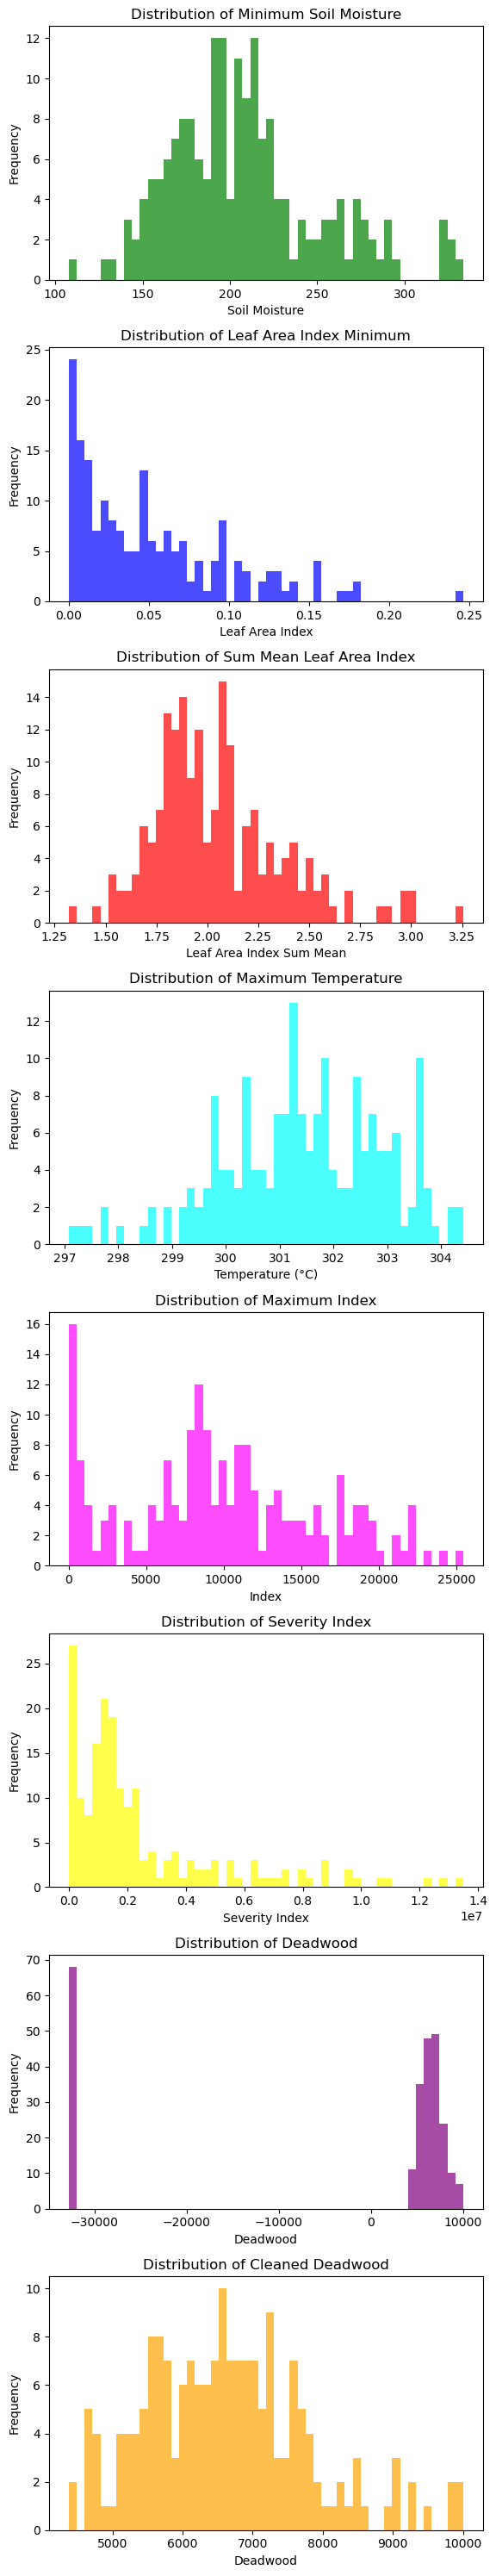

In [99]:
import matplotlib.pyplot as plt

# Setting up the figure and axes for the histograms
fig, axes = plt.subplots(8, 1, figsize=(6, 30), dpi=100)  # 8 rows, 1 column, adjust size and resolution as necessary

# Histogram for Minimum Soil Moisture
axes[0].hist(sm_min_flat, bins=50, color='green', alpha=0.7)
axes[0].set_title('Distribution of Minimum Soil Moisture')
axes[0].set_xlabel('Soil Moisture')
axes[0].set_ylabel('Frequency')

# Histogram for Leaf Area Index Minimum
axes[1].hist(lai_min_flat, bins=50, color='blue', alpha=0.7)
axes[1].set_title('Distribution of Leaf Area Index Minimum')
axes[1].set_xlabel('Leaf Area Index')
axes[1].set_ylabel('Frequency')

# Histogram for Sum Mean of Leaf Area Index
axes[2].hist(lai_sum_mean_flat, bins=50, color='red', alpha=0.7)
axes[2].set_title('Distribution of Sum Mean Leaf Area Index')
axes[2].set_xlabel('Leaf Area Index Sum Mean')
axes[2].set_ylabel('Frequency')

# Histogram for Maximum Temperature
axes[3].hist(t_max_flat, bins=50, color='cyan', alpha=0.7)
axes[3].set_title('Distribution of Maximum Temperature')
axes[3].set_xlabel('Temperature (°C)')
axes[3].set_ylabel('Frequency')

# Histogram for Maximum Index
axes[4].hist(index_max_flat, bins=50, color='magenta', alpha=0.7)
axes[4].set_title('Distribution of Maximum Index')
axes[4].set_xlabel('Index')
axes[4].set_ylabel('Frequency')

# Histogram for Severity Index
axes[5].hist(index_severity_flat, bins=50, color='yellow', alpha=0.7)
axes[5].set_title('Distribution of Severity Index')
axes[5].set_xlabel('Severity Index')
axes[5].set_ylabel('Frequency')

# Histogram for Deadwood
axes[6].hist(deadwood_flat, bins=50, color='purple', alpha=0.7)
axes[6].set_title('Distribution of Deadwood')
axes[6].set_xlabel('Deadwood')
axes[6].set_ylabel('Frequency')

# Histogram for Cleaned Deadwood (y_clean)
axes[7].hist(y_clean, bins=50, color='orange', alpha=0.7)
axes[7].set_title('Distribution of Cleaned Deadwood')
axes[7].set_xlabel('Deadwood')
axes[7].set_ylabel('Frequency')

# Improving layout to prevent overlap
plt.tight_layout()
plt.show()


In [113]:
# Initialize the Random Forest regressor
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=79238)

rf = RandomForestRegressor(n_estimators=1500, random_state=1, oob_score=True )

# Train the model
rf.fit(X_train, y_train)

print(rf.oob_score_)

0.5741813888927636


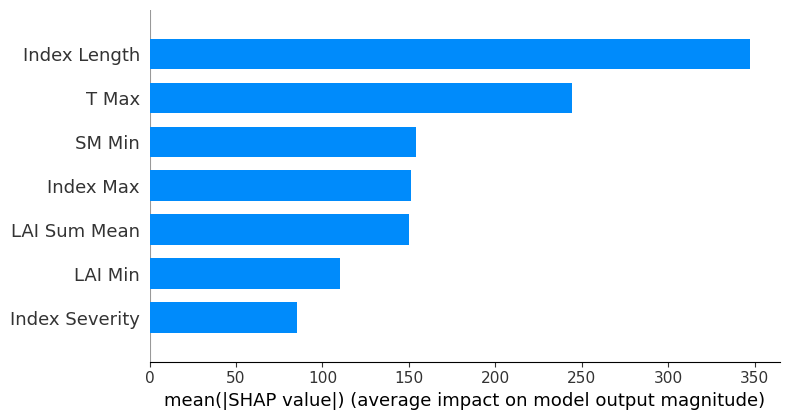

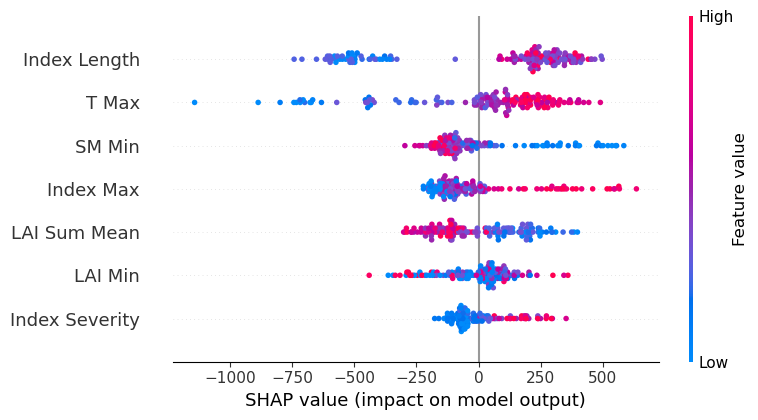

NameError: name 'shap_values_single' is not defined

In [102]:
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Initialize and train the model (assuming this has been done as shown previously)
# rf = RandomForestRegressor(n_estimators=1000, random_state=1, oob_score=True)
# rf.fit(X_train, y_train)

# Initialize SHAP Explainer
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Plot global feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=['SM Min', 'LAI Min', 'LAI Sum Mean', 'T Max', 'Index Max', 'Index Severity', 'Index Length'])

# Detailed dot plot for all features
shap.summary_plot(shap_values, X_train, plot_type='dot', feature_names=['SM Min', 'LAI Min', 'LAI Sum Mean', 'T Max', 'Index Max', 'Index Severity', 'Index Length'])

# Waterfall plot for the first instance in the test set
shap.waterfall_plot(explainer.expected_value, shap_values_single, feature_names=['SM Min', 'LAI Min', 'LAI Sum Mean', 'T Max', 'Index Max', 'Index Severity', 'Index Length'])

# Show the plots
plt.show()


# colinearity / correlation

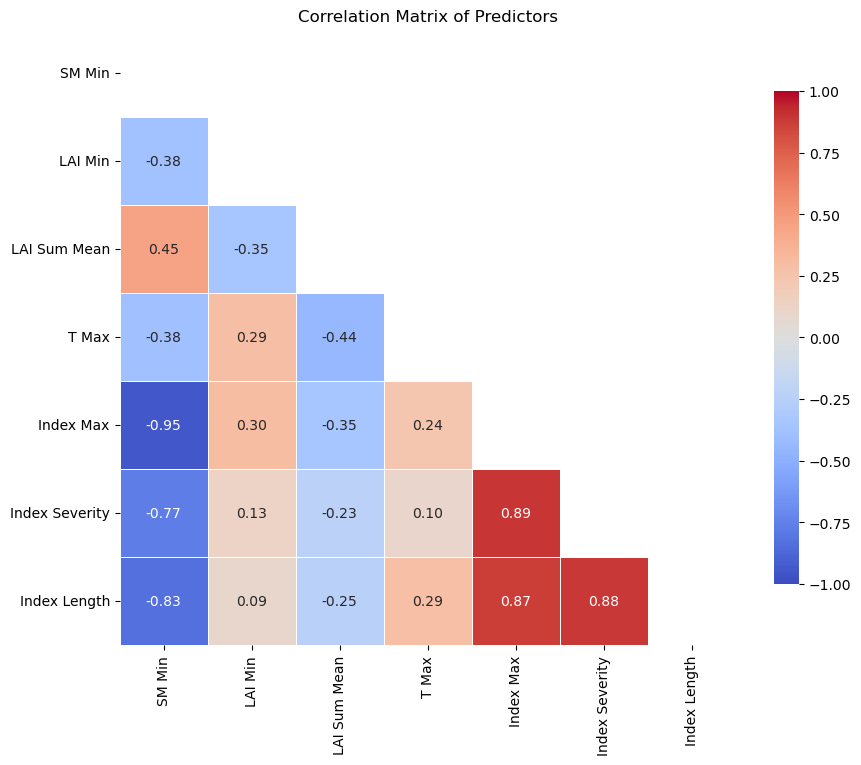

In [118]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_clean is a numpy array with your cleaned predictors
# Create a DataFrame for better handling with columns named according to your predictors
df_predictors = pd.DataFrame(X_clean, columns=['SM Min', 'LAI Min', 'LAI Sum Mean', 'T Max', 'Index Max', 'Index Severity', 'Index Length'])

# Compute the correlation matrix
corr_matrix = df_predictors.corr()

# Generate a mask for the upper triangle (optional, for aesthetics)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmax=1, vmin=-1, square=True, linewidths=.5, cbar_kws={"shrink": .8})

# Add titles and labels for clarity
plt.title('Correlation Matrix of Predictors')
plt.show()
